# Workshop 5 - A random forest pixel classifier

This week we had a quick look at the usage of ML algorithms in image analysis.

The lectures gave a very broad and general overview of different ML algorithms.

In this workshop we will take a much more practical approach and build a pixel classifier using Random Forests (RF).

# Learning objectives

At the end of this workshop you should be able to:

- Train a classifier using a set of pixel-level labelled training data
- Predict the class of each pixel in a new image using the trained classifier
- Measure the accuracy of the classifier using different metrics

## Introduction

### Random Forests

Random Forests is a supervised learning algorithm that works by generating a large number of classification trees, that work on a bootstrapped sample of the training observations and of the training features.

For the context of this workshop, you don't need to exactly know how RF works, but if you want to refresh your mind, I have attached the slides from the IBMS3 lecture you should have all had last year.

### Aim of the task

For this workshop we want to train a pixel classifier that can classify pixels in an image into a certain number of classes.

We will provide one image and label just a few pixels of different classes, and hopefully RF will work its magic and classify the rest! We will then try to classify new images.

We will try a few different things and try to see how good our classifier is, by comparing our results with ground truth segmentation. 

## The data

I have included 4 images of DAPI-stained nuclei (source: Florian Kromp et al. 2020, ["An annotated fluorescence image dataset for training nuclear segmentation methods"](https://www.nature.com/articles/s41597-020-00608-w), CC0) and corresponding ground truth labels. Note that, while the ground truth labels show instance segmentations, we will only do a semantic segmentation here. We will therefore convert the ground truth labels to a binary mask.

Let's start by plotting the images and their GT labels.

['Neuroblastoma1.tif', 'Neuroblastoma2.tif', 'Normal1.tif', 'Normal2.tif']


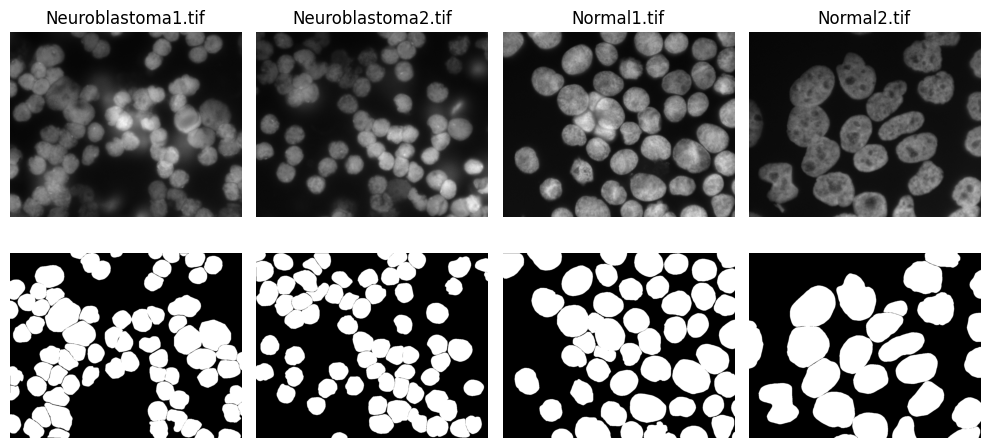

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os

# The names of the folders where our files are stored
# The file naming is the same in the two folders
GT_folder = "GT"
img_folder = "Images"

# Read the filenames of the images
filenames = os.listdir(img_folder)
print(filenames)

fig, ax = plt.subplots(2, 4, figsize=(10, 5))

for i,f in enumerate(filenames):
    # Read the image
    img = plt.imread(os.path.join(img_folder, f))
    # Plot the image
    ax[0, i].imshow(img, cmap='gray')
    # Set the title
    ax[0, i].set_title(f)
    ax[0, i].axis('off')

for i,f in enumerate(filenames):
    # Read the ground truth
    gt = plt.imread(os.path.join(GT_folder, f))
    # Convert to binary mask
    gt = gt > 0
    # Plot the GT
    ax[1, i].imshow(gt, cmap='gray')
    ax[1, i].axis('off')

plt.tight_layout()

We will now just mark a few pixels as belonging to a nucleus or the background.
We could manually draw a mask but for the sake of simplicity we'll just select a crop of the image.

Let's find a 200x200 square in the image containing both nuclei and background.
We will start working on the first image (`Normal1.tif`).

In reality, you might do something like this:

![Example of marking a few pixels](Normal1_marked_pixels.jpg)

Here I marked a few background pixels in red and a few nucleus pixels in blue.

For simplicity, here we are going to use a cropped version of the image, but you could try and save a mask with those strokes and fetch the intensity and labels of the non zero pixels to use as training data.

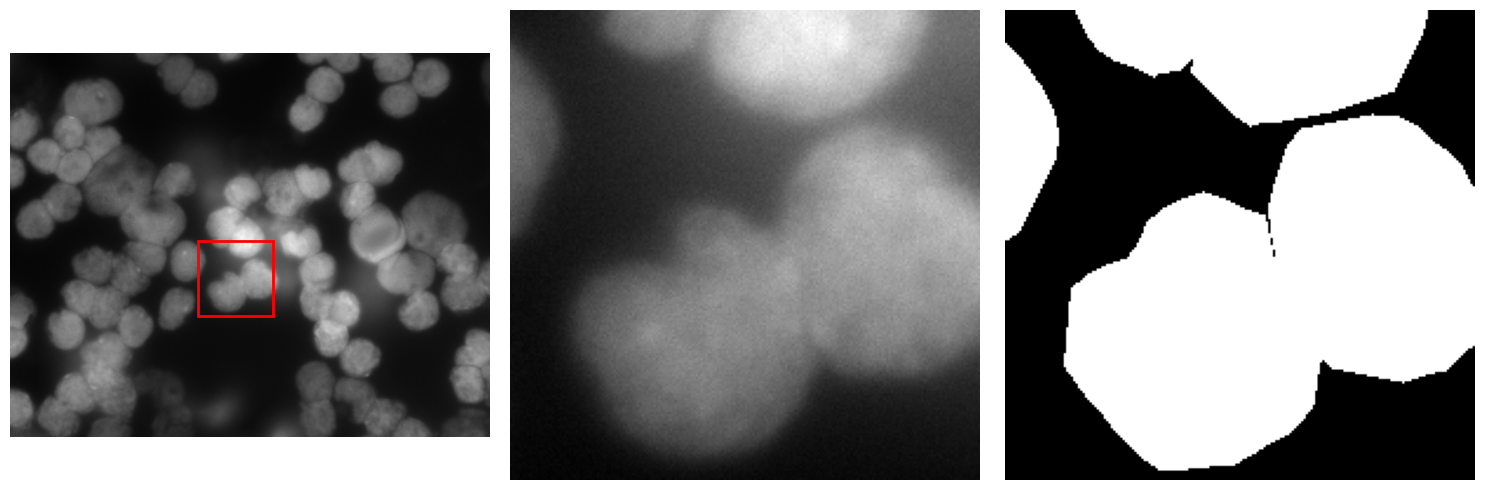

In [3]:
from matplotlib.patches import Rectangle

img = plt.imread(os.path.join(img_folder, filenames[0]))
gt = plt.imread(os.path.join(GT_folder, filenames[0]))
gt = gt > 0

# The coordinates of our training region
# We can just grab GT labels, but in a real-world situation we would probably have to 
# manually "paint" over the image to set the labels 
x, y, width, height = (500, 500, 200, 200)
training = img[y:y+height, x:x+width]

# Plot the image overlaid with the crop and the GT labels
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img, cmap='gray')
rect = Rectangle((x, y), width, height, fill=False, edgecolor='red', linewidth=2)
ax[0].add_patch(rect)

ax[1].imshow(training, cmap='gray')

ax[2].imshow(gt[y:y+height, x:x+width], cmap='gray')

for a in ax:
    a.axis('off')

plt.tight_layout()

The input features need to have observations as rows and features in columns. We only have one feature here (intensity) and 100x100=10000 observations. We can therefore reshape our training data into a single column.

The training labels can be reshaped into a single row.

Remember that this 100x100 square is the only data that our classifier will see during training.

In [4]:
x_train = training.reshape(-1, 1) # -1 means the number of rows will be determined automatically
y_train = gt[y:y+height, x:x+width].ravel()

## Training the classifier

We can finally create a Random Forest classifier.

Import `RandomForestClassifier` from the `sklearn.ensemble` module and initialise it with some parameters of your choice. The number of trees is passed through the `n_estimators` parameter, and you can set the maximum depth of the trees with the `max_depth` parameter.

In [5]:
from sklearn.ensemble import RandomForestClassifier

# Hyperparameters
n_estimators = 100
max_depth = 3

# Initialise the classifier with the hyperparameters of our choice. Set the random state for reproducibility
rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

# Now train the classifier with the pixels of the nuclei and the background
rf = rf.fit(x_train, y_train)

Now that the classifier is trained, we can use it to classify all the pixels in the image! Again, we reshape the image into a single column, then reshape back the results into a 2D image. 

In [6]:
## Prediction 

label_pred = rf.predict(img.ravel().reshape(-1,1))
label_pred = label_pred.reshape(img.shape)

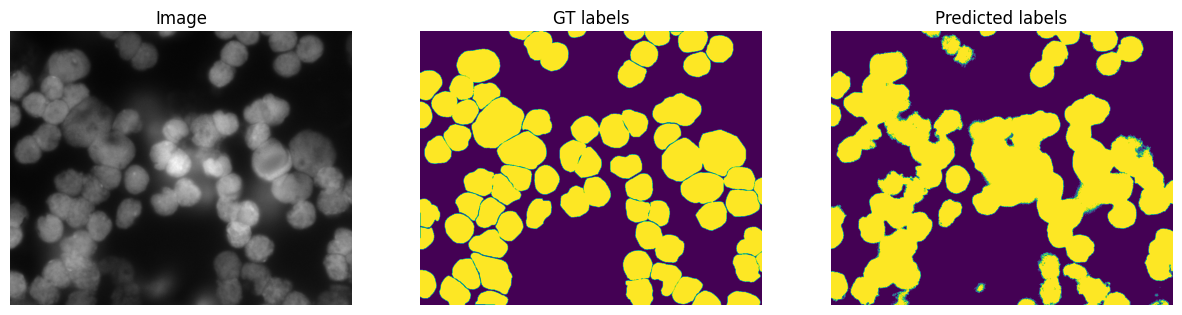

In [7]:
from matplotlib.patches import Rectangle

# Plot the image next to the GT and the predicted labels
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(gt, cmap='viridis')
ax[2].imshow(label_pred, cmap='viridis')

titles = ['Image', 'GT labels', 'Predicted labels']
for i, a in enumerate(ax):
    a.axis('off')
    a.set_title(titles[i])

That is pretty good! Even just by using a single feature (the intensity) the classifier does a good job. This is because the two classes are clearly separable by the intensity. 

The classifier is not perfect, though, failing especially at the edges of cells. 
Let's see how this performs on the other images

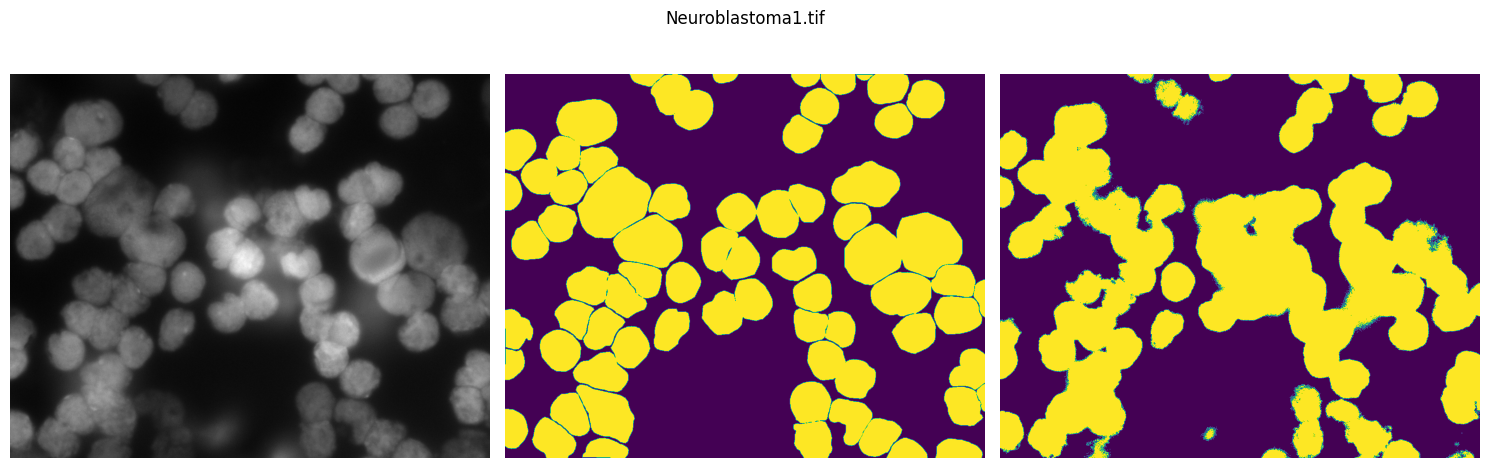

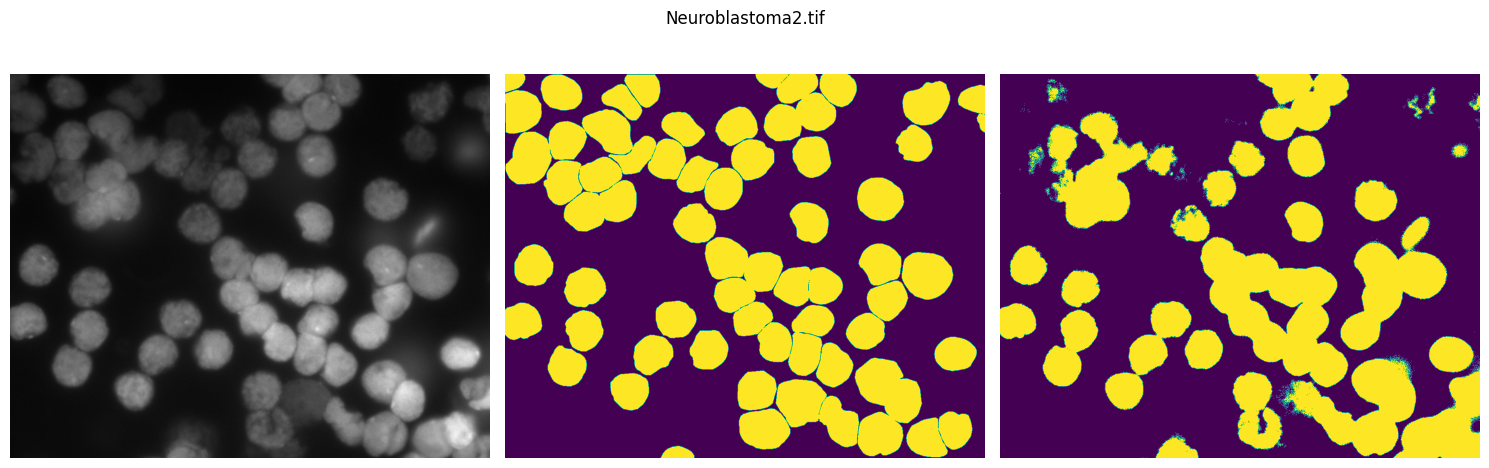

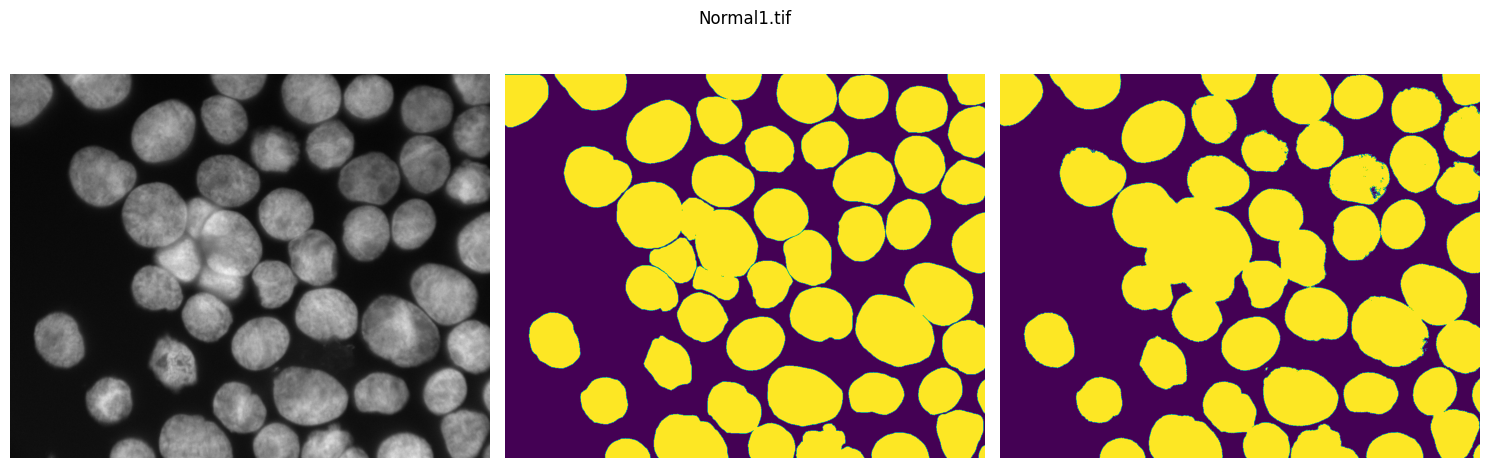

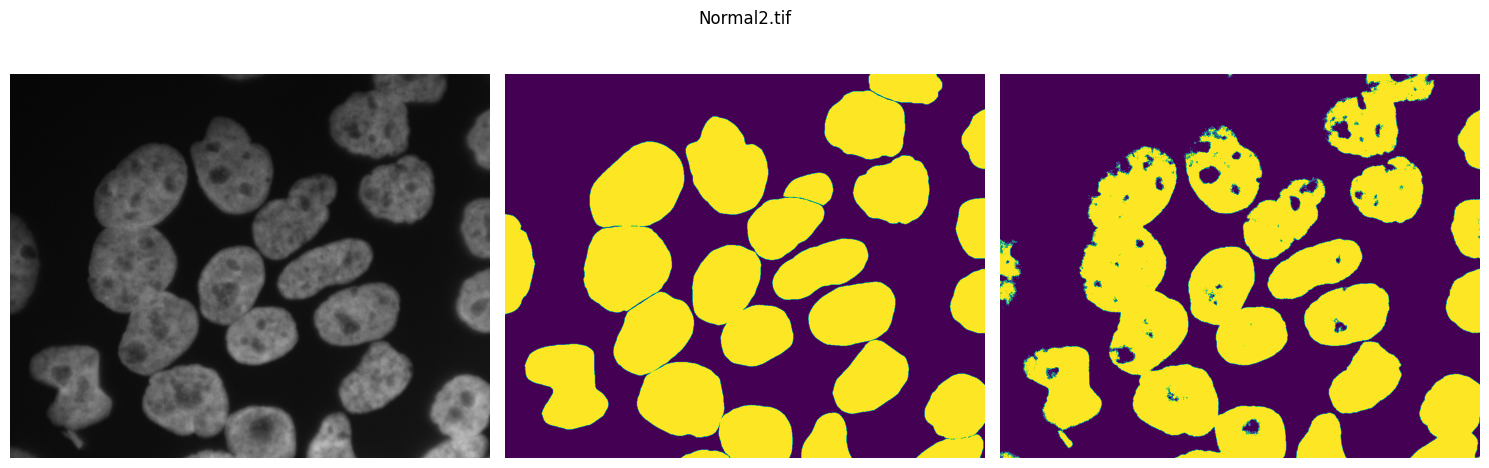

In [9]:
for f in filenames:
    # Read the image
    img = plt.imread(os.path.join(img_folder, f))
    # Read the ground truth
    gt = plt.imread(os.path.join(GT_folder, f))
    # Convert to binary mask
    gt = gt > 0
    # Predict the labels
    label_pred = rf.predict(img.ravel().reshape(-1,1))
    label_pred = label_pred.reshape(img.shape)
    # Plot the image
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f)
    ax[0].imshow(img, cmap='gray')
    # Plot the GT
    ax[1].imshow(gt, cmap='viridis')
    # Plot the predicted labels
    ax[2].imshow(label_pred, cmap='viridis')
    for a in ax:
        a.axis('off')
    plt.tight_layout()

## Accuracy metrics

Before we move onto improving our classifier, we need a way to assess the goodness of our model.

### Pixel accuracy 

A simple solution is to count the percentage of correctly classified pixels. This is called **pixel accuracy** and is defined as:

$\text{Pixel accuracy} = \Large \frac{\text{correctly classified pixels}}{\text{total pixels}}$

This is a very simple metric, but it can be **extremely misleading**. Say that 95% of your image is background and your classifier predicts that every single pixel is background... you still end up with 95% accuracy, which is obviously not great in this case!

*Can we do better?*

Two commonly used metrics for evaluating segmentation are the **IoU** (intersection over union, or Jaccard coefficient) and the **F1 score** (or Dice coefficient).

### IoU

**IoU** is defined as:

$IoU = \Large \frac{\text{intersection of pixels}}{\text{union of pixels}}$

This is calculated for each class and then averaged.

The *intersection* is the number of pixels that are classified in the same way (e.g. background) in both GT and prediction.
The *union* is the total number of non-overlapping pixels, classified in some way (e.g. background) in GT or prediction.


### F1 score

The F1 score is defined as:

$F1 = \Large \frac{2 \times \text{intersection of pixels}}{\text{union of pixels} + \text{intersection of pixels}}$


Both the Iou and the F1 score range from 0 to 1; they are very similar, and always correlated. However, they might give slightly different results depending on the problem (see [this discussion on the topic](https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou/276144)).  


So, let's define three functions to calculate these metrics

Neuroblastoma1.tif - Pixel accuracy: 0.8934303283691406 - IoU: 0.7846588114864667 - F1 score: 0.8793376150513763
Neuroblastoma2.tif - Pixel accuracy: 0.8684051513671875 - IoU: 0.7016425882873907 - F1 score: 0.8246650537743713
Normal1.tif - Pixel accuracy: 0.9757194519042969 - IoU: 0.9548395153176701 - F1 score: 0.9768981114160714
Normal2.tif - Pixel accuracy: 0.9387954711914063 - IoU: 0.8630657019030696 - F1 score: 0.9265005533851781


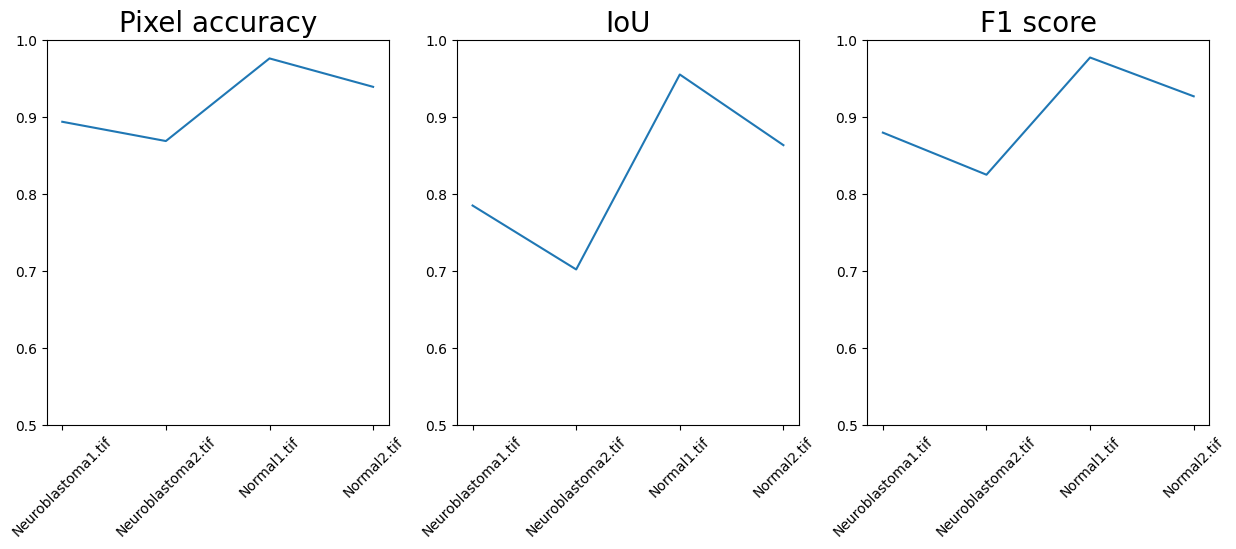

In [10]:
def pixel_accuracy(y_true, y_pred):
    """Returns pixel accuracy of the predicted labels

    Args:
        y_true (np.array): The ground truth labels
        y_pred (np.array): The predicted labels

    Returns:
        float: The pixel accuracy, ranging from 0 to 1
    """
    # Ensure inputs are the same shape
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

    # Calculate the number of pixels that are correctly labelled
    return np.sum(y_true == y_pred) / len(y_true)

def IoU(y_true, y_pred):
    """
    Returns the Intersection over Union (IoU) of the predicted labels
    
        Args:
            y_true (np.array): The ground truth labels
            y_pred (np.array): The predicted labels
    
        Returns:
            float: The IoU, ranging from 0 to 1
        """

    # Ensure inputs are the same shape
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score

def f1_score(y_true, y_pred):
    """
    Returns the F1 score of the predicted labels

        Args:
            y_true (np.array): The ground truth labels
            y_pred (np.array): The predicted labels
    
        Returns:
            float: The F1 score, ranging from 0 to 1
        """

    # Ensure inputs are the same shape
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    
    F1 = (2 * np.sum(intersection)) / (np.sum(union) + np.sum(intersection))

    return F1

# Store the results of the predictions in arrays
F1_scores = []
IoU_scores = []
pixel_accuracies = []

for f in filenames:
    # Read the image
    img = plt.imread(os.path.join(img_folder, f))
    # Read the ground truth
    gt = plt.imread(os.path.join(GT_folder, f))
    # Convert to binary mask and linearize
    gt = gt > 0
    gt = gt.ravel()
    # Predict the labels
    label_pred = rf.predict(img.ravel().reshape(-1,1))


    accuracy = pixel_accuracy(gt, label_pred)
    pixel_accuracies.append(accuracy)
    IoU_score = IoU(gt, label_pred)
    IoU_scores.append(IoU_score)
    F1_score = f1_score(gt, label_pred)
    F1_scores.append(F1_score)
    
    print(f"{f} - Pixel accuracy: {accuracy} - IoU: {IoU_score} - F1 score: {F1_score}")

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(filenames, pixel_accuracies)
ax[0].set_title('Pixel accuracy', fontsize=20)
ax[1].plot(filenames, IoU_scores)
ax[1].set_title('IoU', fontsize=20)
ax[2].plot(filenames, F1_scores)
ax[2].set_title('F1 score', fontsize=20)

for a in ax:
    a.set_ylim(0.5, 1)
    a.tick_params(axis='x', labelrotation=45)

plt.show()

In this case, since the two classes are fairly balanced, the pixel accuracy can be used as a reliable, measure.

The three measures are essentially in agreement with each other, at around 80%, with IoU generally a bit more conservative.

We can also see that the first image has slightly higher scores than the other three. This is likely because the training data only comes from this image, and the classifier is not able to generalise to other images, especially on the neuroblastoma images, which are visually very different.

## Extra exercises

1. Try to add new training data from another image. Does that improve the results? 

We only used a single feature (intensity) to train the classifier. This is OK here because intensity discriminates well nuclei and background, however, you could improve classification by passing more features to the classifier. For example you could add the gradient magnitude, or the entropy, or GLCM features! You could also calculate those features on a series of gaussian-filtered versions of the image (with different $\sigma$), to get information from neighbouring pixels as well. 

2. Try segmenting the `skin.jpg` image similarly to what we have done above! I am not providing GT for this image, but you can evaluate the results visually. 

## Exercise 1

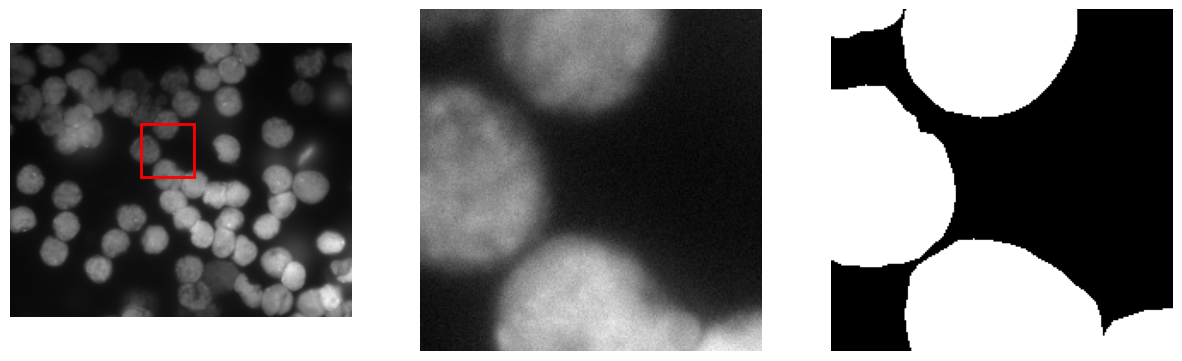

In [11]:
# Add some training data from one of the neuroblastoma images

img = plt.imread(os.path.join(img_folder, filenames[1]))
gt = plt.imread(os.path.join(GT_folder, filenames[1]))
gt = gt > 0

x2, y2, w2, h2 = (490, 300, 200, 200)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img, cmap='gray')
rect = Rectangle((x2, y2), w2, h2, fill=False, edgecolor='red', linewidth=2)
ax[0].add_patch(rect)
ax[1].imshow(img[y2:y2+h2, x2:x2+w2], cmap='gray')
ax[2].imshow(gt[y2:y2+h2, x2:x2+w2], cmap='gray')

for a in ax:
    a.axis('off')
plt.show()

In [12]:
# Add new training data
x_train = np.concatenate([x_train, img[y2:y2+h2, x2:x2+w2].reshape(-1,1)], axis=0)
y_train = np.concatenate([y_train, gt[y2:y2+h2, x2:x2+w2].ravel()], axis=0)

Neuroblastoma1.tif - Pixel accuracy: 0.9120315551757813 - IoU: 0.828900605292563 - F1 score: 0.9064468598171486
Neuroblastoma2.tif - Pixel accuracy: 0.8860397338867188 - IoU: 0.7553685603479902 - F1 score: 0.8606381331089162
Normal1.tif - Pixel accuracy: 0.9774787902832032 - IoU: 0.9588756168169875 - F1 score: 0.9790061283983736
Normal2.tif - Pixel accuracy: 0.9692710876464844 - IoU: 0.9318658937008474 - F1 score: 0.9647314513283171


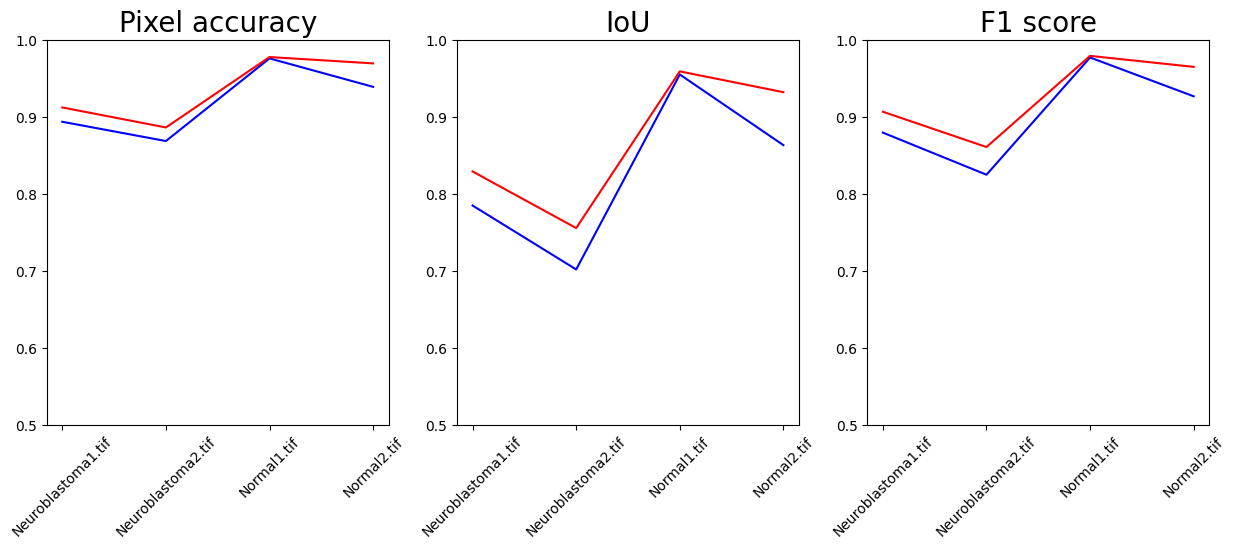

In [13]:
# Re-run the classification
rf2 = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
rf2.fit(x_train, y_train)

# Store the results of the predictions in arrays
F1_scores_2 = []
IoU_scores_2 = []
pixel_accuracies_2 = []

for f in filenames:
    # Read the image
    img = plt.imread(os.path.join(img_folder, f))
    # Read the ground truth
    gt = plt.imread(os.path.join(GT_folder, f))
    # Convert to binary mask and linearize
    gt = gt > 0
    gt = gt.ravel()
    # Predict the labels
    label_pred = rf2.predict(img.ravel().reshape(-1,1))


    accuracy = pixel_accuracy(gt, label_pred)
    pixel_accuracies_2.append(accuracy)
    IoU_score = IoU(gt, label_pred)
    IoU_scores_2.append(IoU_score)
    F1_score = f1_score(gt, label_pred)
    F1_scores_2.append(F1_score)
    
    print(f"{f} - Pixel accuracy: {accuracy} - IoU: {IoU_score} - F1 score: {F1_score}")

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(filenames, pixel_accuracies, c="blue")
ax[0].plot(filenames, pixel_accuracies_2, c="red")
ax[0].set_title('Pixel accuracy', fontsize=20)
ax[1].plot(filenames, IoU_scores, c="blue")
ax[1].plot(filenames, IoU_scores_2, c="red")
ax[1].set_title('IoU', fontsize=20)
ax[2].plot(filenames, F1_scores, c="blue")
ax[2].plot(filenames, F1_scores_2, c="red")
ax[2].set_title('F1 score', fontsize=20)

for a in ax:
    a.set_ylim(0.5, 1)
    a.tick_params(axis='x', labelrotation=45)

plt.show()

Adding an extra set of training data has improved the results, particularly in the neuroblastoma images!

In some cases, "biasing" your training data could hlep, e.g. by specifically labelling pixels that are between cells, or in very busy parts of the image, so that the classifier learns to deal with those cases. However, you should be careful to balance the training data, and to not overfit the classifier.

## Exercise 2

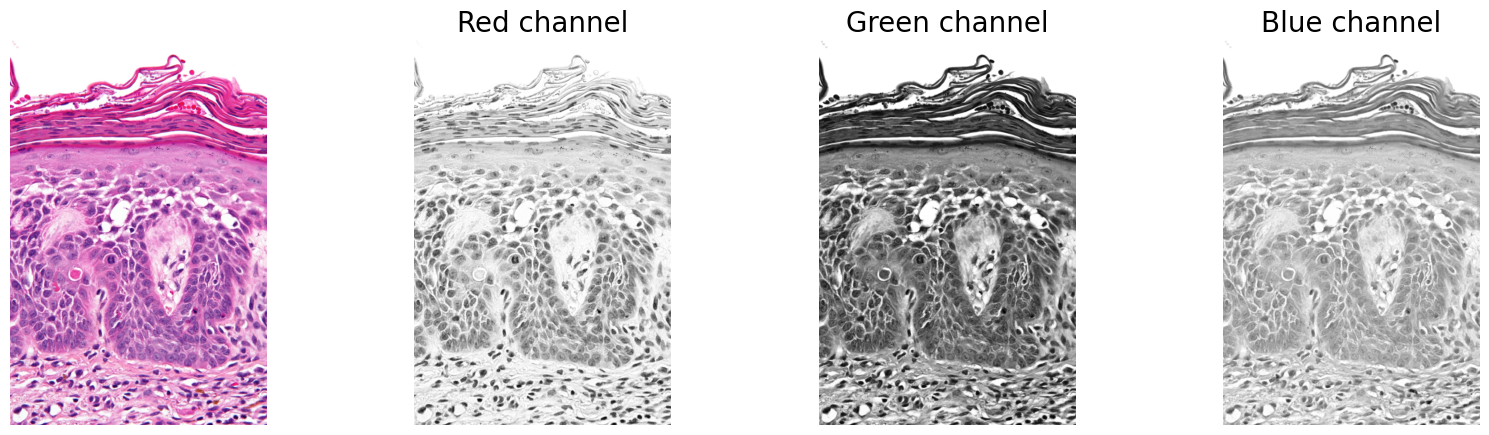

In [14]:
# Read the skin.jpg image

skin = plt.imread('skin.jpg')

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(skin)
ax[1].imshow(skin[:,:,0], cmap='gray')
ax[1].set_title('Red channel', fontsize=20)
ax[2].imshow(skin[:,:,1], cmap='gray')
ax[2].set_title('Green channel', fontsize=20)
ax[3].imshow(skin[:,:,2], cmap='gray')
ax[3].set_title('Blue channel', fontsize=20)

for a in ax:
    a.axis('off')

We already have 3 features (intensity in the 3 channels)

Let's get the gradient magnitude and the entropy in each channel

In [15]:
from skimage.filters import sobel
from skimage.filters.rank import entropy

all_features = np.concatenate([skin[:,:,0].reshape(-1,1),  # Red channel
                                skin[:,:,1].reshape(-1,1), # Green channel
                                skin[:,:,2].reshape(-1,1), # Blue channel
                                sobel(skin[:,:,0]).reshape(-1,1), # Gradient magnitude in red channel
                                sobel(skin[:,:,1]).reshape(-1,1), # Gradient magnitude in green channel
                                sobel(skin[:,:,2]).reshape(-1,1), # Gradient magnitude in blue channel
                                entropy(skin[:,:,0], selem=np.ones((5, 5))).reshape(-1,1),  # Entropy in red channel
                                entropy(skin[:,:,1], selem=np.ones((5, 5))).reshape(-1,1),  # Entropy in green channel
                                entropy(skin[:,:,2], selem=np.ones((5, 5))).reshape(-1,1)], # Entropy in blue channel 
                                axis=1)

print(all_features.shape)

/tmp/ipykernel_1008799/442645064.py:10: FutureWarning: `selem` is a deprecated argument name for `entropy`. It will be removed in version 1.0. Please use `footprint` instead.
  entropy(skin[:,:,0], selem=np.ones((5, 5))).reshape(-1,1),  # Entropy in red channel
/tmp/ipykernel_1008799/442645064.py:11: FutureWarning: `selem` is a deprecated argument name for `entropy`. It will be removed in version 1.0. Please use `footprint` instead.
  entropy(skin[:,:,1], selem=np.ones((5, 5))).reshape(-1,1),  # Entropy in green channel
/tmp/ipykernel_1008799/442645064.py:12: FutureWarning: `selem` is a deprecated argument name for `entropy`. It will be removed in version 1.0. Please use `footprint` instead.
  entropy(skin[:,:,2], selem=np.ones((5, 5))).reshape(-1,1)], # Entropy in blue channel


(12166656, 9)


We have 9 features now, and we can use them for training our classifier.

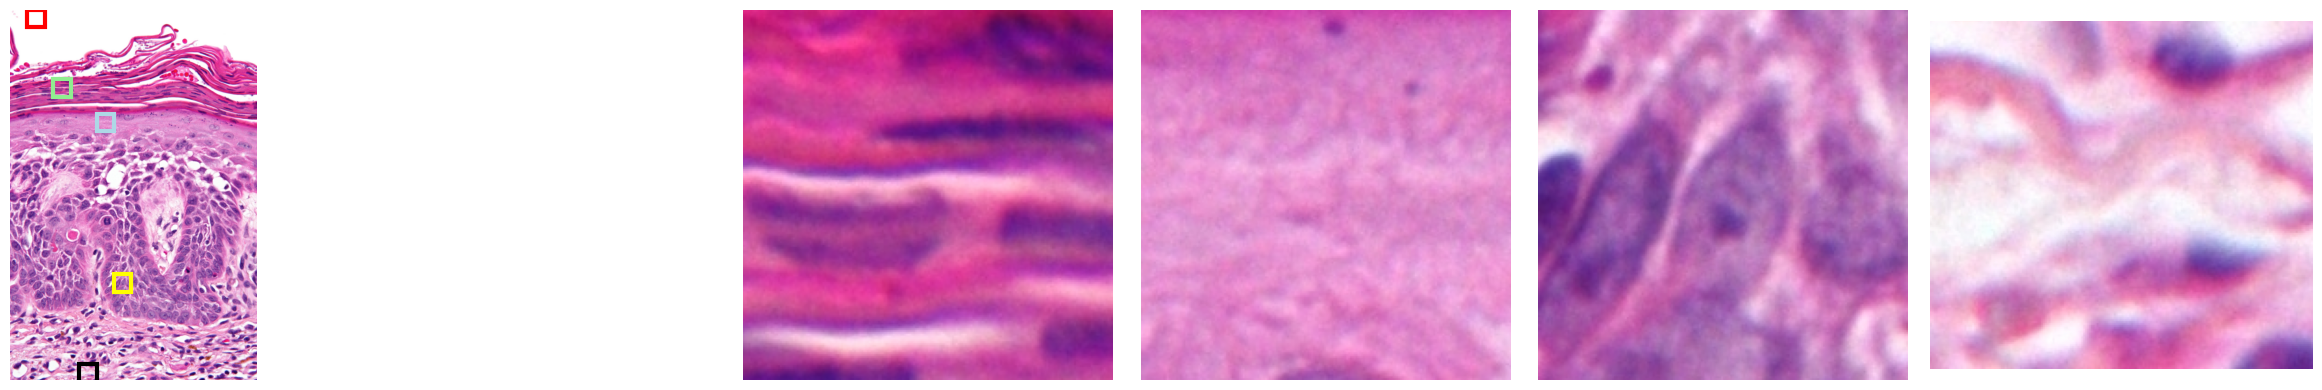

In [16]:
# Define some training data
x = [200, 500, 1000, 1200, 800]
y = [0, 800, 1200, 3050, 4090]
w = 200
h = 200

fig, ax = plt.subplots(1, 6, figsize=(24, 4))

ax[0].imshow(skin)

box_colors = ['red', 'lightgreen', 'lightblue', 'yellow', 'black']

for i in range(5):
    ax[i+1].imshow(skin[y[i]:y[i]+h, x[i]:x[i]+w, :])
    rect = Rectangle((x[i], y[i]), w, h, fill=False, edgecolor=box_colors[i], linewidth=3)
    ax[0].add_patch(rect)

for a in ax:
    a.axis('off')

plt.tight_layout()

In [18]:
x_train = np.empty(shape=(0, 9))
y_train = np.empty(shape=(0))

for i in range(5):
    region_features = np.concatenate([skin[y[i]:y[i]+h, x[i]:x[i]+w, 0].reshape(-1, 1),
                                        skin[y[i]:y[i]+h, x[i]:x[i]+w, 1].reshape(-1, 1),
                                        skin[y[i]:y[i]+h, x[i]:x[i]+w, 2].reshape(-1, 1),
                                        sobel(skin[y[i]:y[i]+h, x[i]:x[i]+w, 0]).reshape(-1, 1),
                                        sobel(skin[y[i]:y[i]+h, x[i]:x[i]+w, 1]).reshape(-1, 1),
                                        sobel(skin[y[i]:y[i]+h, x[i]:x[i]+w, 2]).reshape(-1, 1),
                                        entropy(skin[y[i]:y[i]+h, x[i]:x[i]+w, 1], footprint=np.ones((5, 5))).reshape(-1, 1),
                                        entropy(skin[y[i]:y[i]+h, x[i]:x[i]+w, 0], footprint=np.ones((5, 5))).reshape(-1, 1),
                                        entropy(skin[y[i]:y[i]+h, x[i]:x[i]+w, 2], footprint=np.ones((5, 5))).reshape(-1, 1)],
                                        axis=1)
    x_train = np.concatenate([x_train, region_features], axis = 0)
    y_train = np.concatenate([y_train, np.ones(region_features.shape[0]) * i])

print(x_train.shape)
print(y_train.shape)

(196400, 9)
(196400,)


In [19]:
skin_rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
skin_rf.fit(x_train, y_train)

res = skin_rf.predict(all_features)

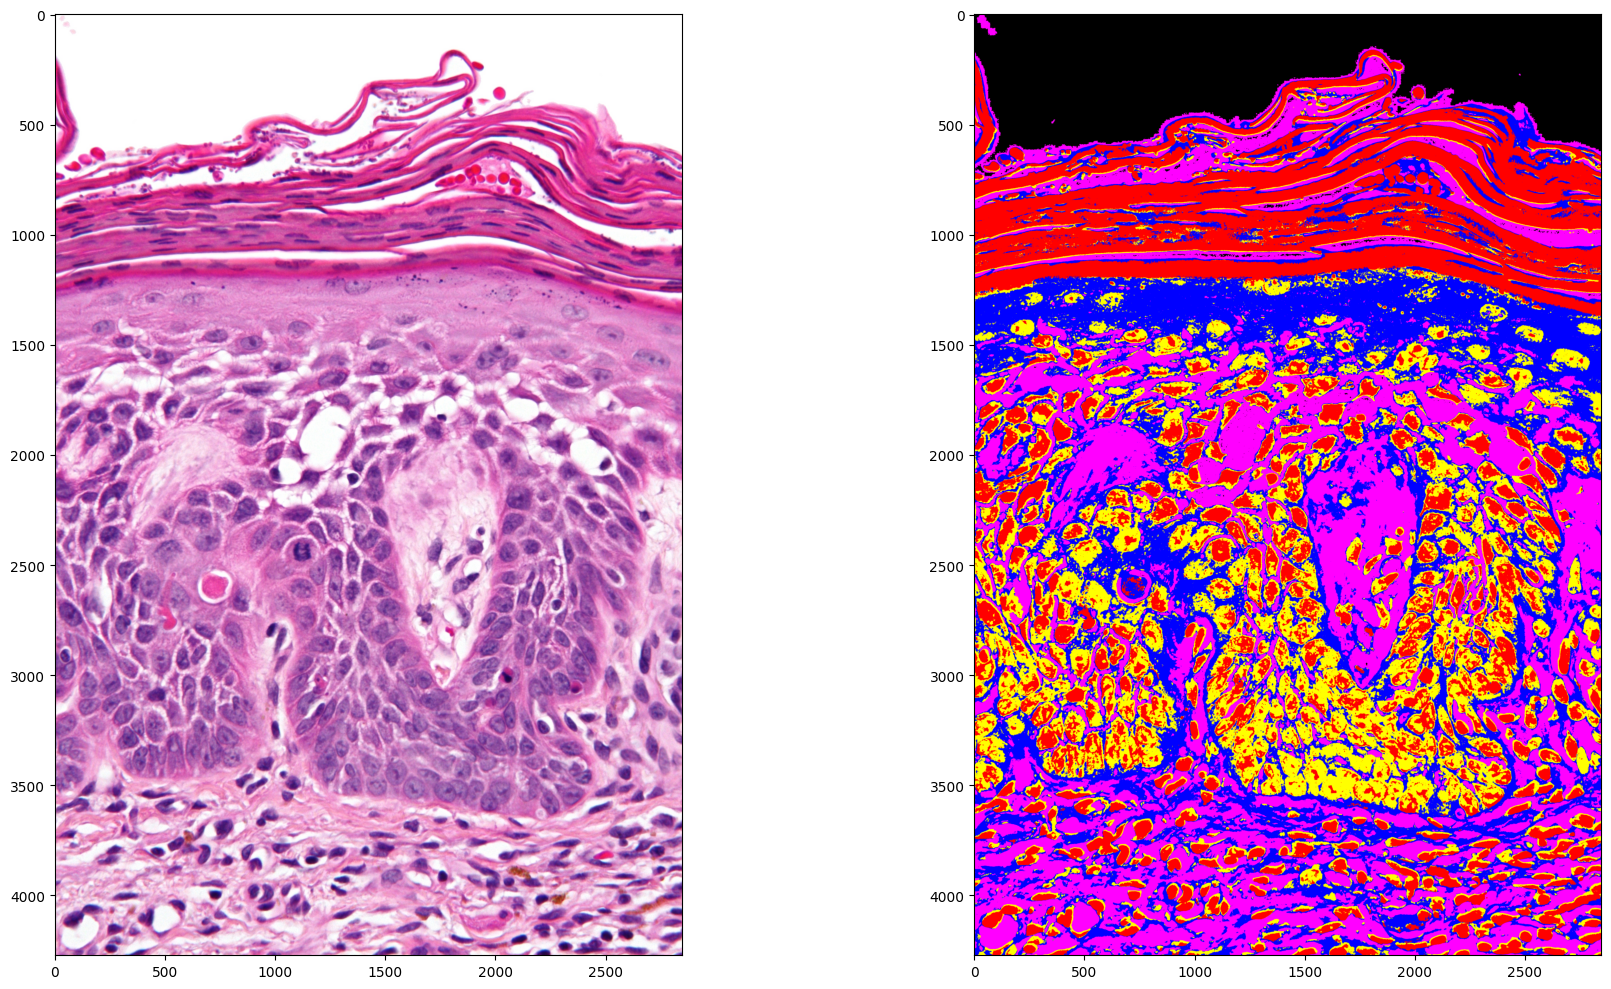

In [20]:
from skimage.color import label2rgb

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(skin)
ax[1].imshow(label2rgb(res.reshape(skin.shape[0], skin.shape[1]), bg_label=0), cmap='gray')

plt.tight_layout()

The segmentation could certainly be improved, by providing better training data, but hopefully this will be a good starting point for you on how to use multiple features!

And that's it! Well done, you made it to the end of the workshop 5! I hope you enjoyed it; if you have any questions, please [ask](mailto:nicola.romano@ed.ac.uk)!